In [1]:
import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, seed_everything
os.chdir("/nfs/students/winter-term-2020/project-4/schwienb/project-4")

In [5]:
from src.data.mnist import MNISTDataModule
from src.data.fashionmnist import FashionMNISTDataModule
from src.data.constant import ConstantDataModule, ConstantDataset, RandomDataset
from src.models.pixelcnn import PixelCNN
from src.models.bg_aug_pixelcnn import BgAugPixelCNN
from src.models.bg_aug_pixelcnn_new import BgAugPixelCNNNew
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
import torch.nn.functional as F
from pytorch_lightning.callbacks import LearningRateMonitor

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(42)


42

In [9]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=5,
   verbose=True,
)
lr_monitor = LearningRateMonitor(logging_interval='step')

model_params = {
#     'bg_aug_max': 0.5,
#     'background_subtraction': False,
#     'residual_connection': True
#     'reg': 0.1
}
dataset_params = {
}

model = PixelCNN
dataset = FashionMNISTDataModule



EarlyStopping mode set to min for monitoring val_loss.


In [10]:
exp = Experiment('PixelCNN_MNIST_Full',
                 model=model, dataset=dataset, model_params=model_params, dataset_params=dataset_params, callbacks=[early_stop_callback, lr_monitor])
exp.setup_new()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.

  | Name   | Type       | Params
--------------------------------------
0 | blocks | Sequential | 1 M   


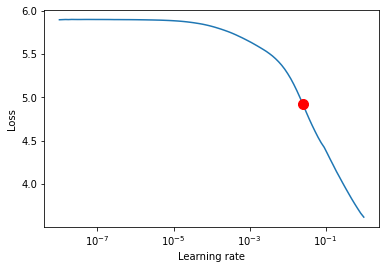

In [11]:
lr_finder = exp.trainer.tuner.lr_find(exp.model, exp.dataset)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
exp.model.lr = new_lr

In [12]:
exp.train()

/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: Found unsupported keys in the lr scheduler dict: ['name']
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.

  | Name   | Type       | Params
--------------------------------------
0 | blocks | Sequential | 1 M   


Traceback (most recent call last):
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [14]:
exp.save()

/nfs/students/winter-term-2020/project-4/schwienb/project-4/src/utils/pixelcnn.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


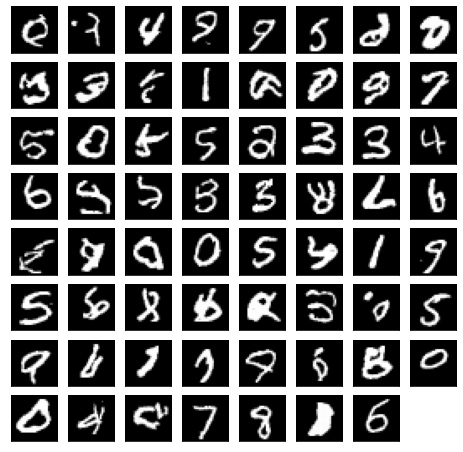

In [13]:
generate_images(exp.model, channels=1)